In [1]:
from matplotlib import pyplot as plt
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor

from tqdm.notebook import trange
%matplotlib notebook

device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [2]:
train_set = CIFAR10(
    download=True,
    root='./dataset',
    train=True,
    transform=ToTensor()
)
test_set = CIFAR10(
    download=True,
    root='./dataset',
    train=False,
    transform=ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


<IPython.core.display.Javascript object>


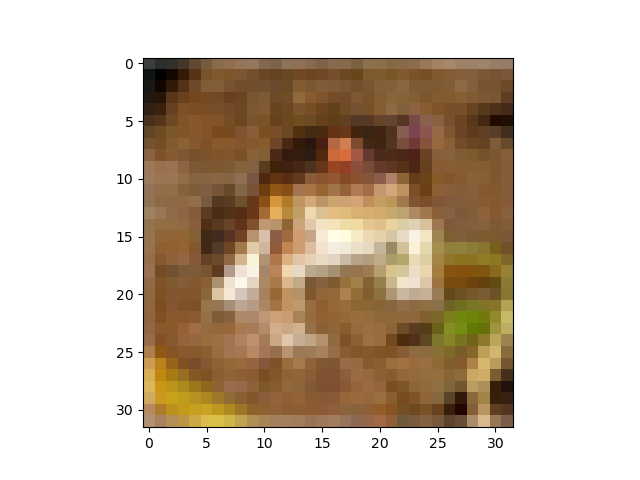

In [3]:
fig, ax = plt.subplots()

def imshow(img, ax=None):
    npimg = img.numpy()
    if ax:
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
imshow(train_set[0][0], ax)

In [4]:
def get_noise(BS=1):
    return torch.randn(BS, 100, requires_grad=True).to(device)

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 5),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 5, stride=2, padding=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 5, stride=2, padding=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 6, stride=1, padding=1),
            nn.BatchNorm2d(3),
            nn.Tanh()
        )
        self.input_layer = nn.Sequential(
            nn.Linear(100, 4*4*512),
            nn.ReLU()
        )
    
    def forward(self, x):
        x = self.input_layer(x)
        x = x.reshape(-1, 512, 4, 4)
        return self.conv(x)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, 6, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, 5, stride=2, padding=2),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, 5, stride=2, padding=2),
            nn.LeakyReLU(),
            nn.Conv2d(256, 512, 5),
            nn.LeakyReLU()
        )
        self.output_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4*4*512, 100),
            nn.LeakyReLU(),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.conv(x)
        return self.output_layer(x)

In [7]:
G = Generator().to(device)
x = G(get_noise())
    
D = Discriminator().to(device)
x.shape, D(x)

(torch.Size([1, 3, 32, 32]),
 tensor([[0.4943]], device='cuda:0', grad_fn=<SigmoidBackward>))

<IPython.core.display.Javascript object>


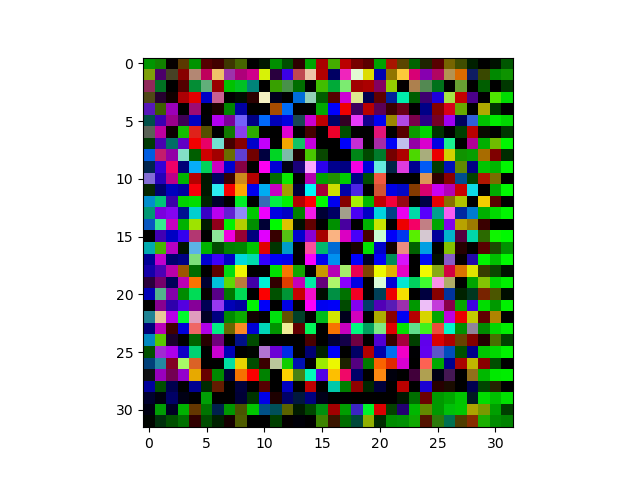

In [8]:
fig, ax = plt.subplots()
imshow(x[0].detach().cpu(), ax)